In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft
import matplotlib.gridspec as gridspec

client = tt.startdask(nthreads=1,n_workers = 52)

client

<Client: 'tcp://127.0.0.1:39773' processes=52 threads=52, memory=416.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34263/status,
Dashboard: /proxy/34263/status,Workers: 52
Total threads: 52,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39773,Workers: 52
Dashboard: /proxy/34263/status,Total threads: 52
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:45927,Total threads: 1
Dashboard: /proxy/44241/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:38097,


# Rather than timeseries, quantify the temporal variability as error bars instead. 

In [2]:

data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40","full-80","beamless-80"]:
# for expt in ["full-40","beamless-40","smooth-40"]:
    path = Path(f"/g/data/nm03/ab8992/postprocessed/figdata/energies") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc")
    times = os.listdir(path)
    times = np.sort(np.array([int(i.split("t0-")[1]) for i in times]))

    data[expt] = None
    for i in range(len(times)):
        try:
            newdata = xr.merge(
                        [
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam_forward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam_backward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam_xterm.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam_forward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam_backward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam_xterm.nc",decode_times= False,decode_cf = False),
                            bathy.rename({"depth":"bathy"}) * -1
                        ]
                    ).expand_dims({"time":[float(times[i])]})
            if data[expt] is None:
                data[expt] = newdata
            else:
                data[expt] = xr.concat(
                    [
                        data[expt],
                        newdata
                    ],
                    dim = "time"
                )
        except Exception as e:
            print(f"Error processing time {times[i]} for experiment {expt}: {e}")

    data[expt].time.values[:] -= data[expt].time.values[0]
    data[expt].time.values[:] /= 24

## POINT IN KLYMAK CORRESPONDS TO:
xb,yb = 224,68

Error processing time 3960 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/energies/full-40/t0-3960/EF_alongbeam.nc'
Error processing time 4680 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/energies/full-40/t0-4680/EF_alongbeam.nc'
Error processing time 5400 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/energies/full-40/t0-5400/EF_alongbeam.nc'
Error processing time 6120 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/energies/full-40/t0-6120/EF_alongbeam.nc'
Error processing time 7560 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/energies/full-40/t0-7560/EF_alongbeam.nc'
Error processing time 8280 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/ener

In [3]:
def contour_mask_singleline(xs,ys,data):
    """
    Returns umask,vmask
    """
    dx = (data.yb[2] - data.yb[1]).values
    if xs[0] == xs[1]: # HANDLE VERTICAL LINE
        return xr.where(
            (np.abs(data.xb + 1e-9 - xs[0]) < dx/2) *
            (data.yb > ys[0]) * 
            (data.yb < ys[1])            
            ,1,0
        ).fillna(0), (data * 0).astype(int)
    if ys[0] == ys[1]: # HANDLE HORIZONTAL LINE
        return data * 0,xr.where(
            (np.abs(data.yb + 1e-9 - ys[0]) < dx/2) *
            (data.xb > xs[0]) * 
            (data.xb < xs[1])
            ,1,0
        ).fillna(0)
    
    ## Deal with an angled line
    m = (ys[1] - ys[0]) / (xs[1] - xs[0])
    c = ys[0] - m * xs[0]

    ## V mask first. So, we need unique points in x
    x_points = np.arange(xs[0],xs[1],dx)
    y_points = m * x_points + c
    # y_points = np.round(y_points,1)
    x_points = np.round(x_points,0)
    vmask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        vmask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )
    ## U mask second. So, we need unique points in y
    y_points = np.arange(np.min(ys),np.max(ys),dx)
    x_points = (y_points - c) / m
    umask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        umask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )

    return umask.astype(int),vmask.astype(int)

def contour_mask_compound(xs,ys,data):
    umask,vmask = contour_mask_singleline(xs[0],ys[0],data)

    length = np.sqrt((xs[0][1] - xs[0][0])**2 + (ys[0][1] - ys[0][0])**2) * 1000
    for i in range(1,len(xs)):
        u,v = contour_mask_singleline(xs[i],ys[i],data)
        umask += u 
        vmask += v 
        length += np.sqrt((xs[i][1] - xs[i][0])**2 + (ys[i][1] - ys[i][0])**2) * 1000

    return xr.merge(
        [xr.where(umask == 0,0,1).rename("umask") , xr.where(vmask == 0,0,1).rename("vmask"),xr.DataArray(length).rename("length")])

def contour_integral(xs,ys,alongbeam,acrossbeam):
    """
    Pass x and y coords of straight line. Need to pre-multiply data to get orientation to line 
    correct as function just integrates along the line. If line is parallel to an axis, just 
    pre multiply alongbeam or acrossbeam by 0 to ensure that we don't integrate over empty dimension.
    """
    if type(xs[0]) == list:
        mask = contour_mask_compound(xs,ys,alongbeam)
        umask = mask["umask"]
        vmask = mask["vmask"]
        length = mask["length"]

    else:
        umask,vmask = contour_mask_singleline(xs,ys,alongbeam)
        # print("Ulength:",umask.sum("xb").sum("yb").values)
        # print("Vlength:",vmask.sum("xb").sum("yb").values)
        length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2) * 1000

    out = (umask * alongbeam).sum("xb").integrate("yb")
    out += (vmask * acrossbeam).sum("yb").integrate("xb")
    out = xr.Dataset({"energy":out,"length":length})
    out["energy"].attrs["Units"] = "kW"
    out["energy"].attrs["length"] = "m"
    return out # Convert km -> m

In [4]:
offset = 0
xs = [[90 + offset, 220 + offset]] 
ys = [ [120, -120]]
pdata = {}
temp = {}

#! EXPERIMENTAL LINE
xs, ys = [[90, 220 - 11]],[ [115, -100]]
xs_north,ys_north = [[0,90]],[[115, 115]]
xs_south,ys_south = [[80,220-11]],[[-100, -100]]

for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40","full-80","beamless-80"]:
    pdata[expt] = {}
    for direction in ["","_forward","_backward"]:
        E = contour_integral(
            xs,
            ys,
            data[expt][f"EF_alongbeam{direction}"],
            data[expt][f"EF_acrossbeam{direction}"]
        ).energy
        E += contour_integral(
            xs_north,
            ys_north,
            data[expt][f"EF_alongbeam{direction}"],
            data[expt][f"EF_acrossbeam{direction}"]
        ).energy
        E -= contour_integral(
            xs_south,
            ys_south,
            data[expt][f"EF_alongbeam{direction}"],
            data[expt][f"EF_acrossbeam{direction}"]
        ).energy



        pdata[expt][f"EF{direction}_mean"] = E.mean("time")
        pdata[expt][f"EF{direction}_std"] = E.std("time")
        temp[expt] = E
for res in ["10","20","40","80"]:
    pdata[f"anom-{res}"] = {}
    for key in pdata["full-40"].keys():
        if key == "EF_std":
            pdata[f"anom-{res}"][key] = (temp[f"full-{res}"] - temp[f"beamless-{res}"]).std("time")
        else:
            pdata[f"anom-{res}"][key] = pdata[f"full-{res}"][key] - pdata[f"beamless-{res}"][key]

## Prototype 'flux' plot

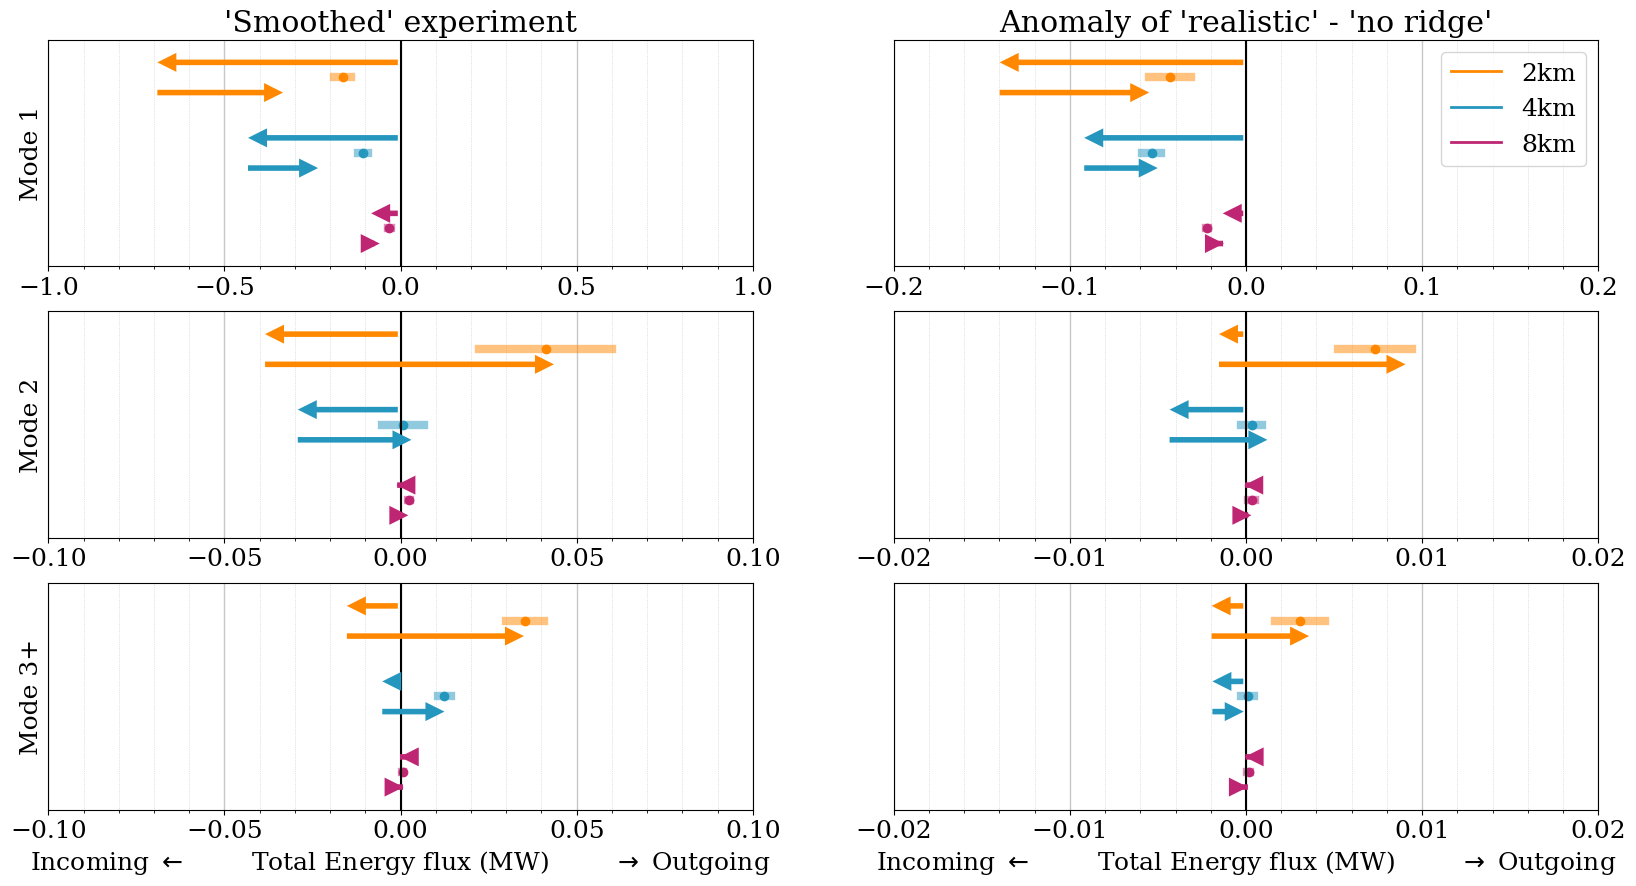

In [6]:
from matplotlib.lines import Line2D
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
# Plot a vertical line, add an arrowhead to the top end
# Coordinates for the vertical line

def add_point(ax,ypoint = 1,efmean = 1,efin = 1,efout = 1,std = 0,color = "black",mode = [0]):
    efmean = efmean.isel(mode = mode).sum("mode").values * 1e-6
    efin = np.abs(efin).isel(mode = mode).sum("mode").values * 1e-6
    efout = np.abs(efout).isel(mode = mode).sum("mode").values * 1e-6
    std = std.isel(mode = mode).sum("mode").values * 1e-6
    vspace = 0.2
    ax.plot(np.array([efmean - std / 2,efmean + std/2]),np.array([ypoint,ypoint]),color = color, lw = 6,alpha = 0.5)
    ax.scatter(efmean,ypoint,marker = "o",color = color)
    ax.annotate("",
                xytext=(0, ypoint + vspace),
                xy=(- efin, ypoint + vspace),
                arrowprops=dict(arrowstyle="-|>", color=color, lw=4,capstyle='butt',joinstyle='miter'))
    ax.annotate("",
                xy=(efout-efin, ypoint - vspace),
                xytext=( - efin, ypoint - vspace),
                arrowprops=dict(arrowstyle="-|>", color=color, lw=4,capstyle='butt',joinstyle='miter'))
    return ax

## Prototype plot of smooth experiments per resolution and mode
fig,ax = plt.subplots(3,2,figsize=(20, 10))

colours = ['#be2573','#2596be','#ff8800',"#00bf7c"]

for i,res in enumerate(["10","20","40","80"]):
    if res != "80":
        d = pdata[f"smooth-{res}"]
        add_point(ax[0,0],
                ypoint = i,
                efmean = d["EF_mean"],
                efin = d["EF_forward_mean"],
                efout = d["EF_backward_mean"],
                std = d["EF_std"],
                color = colours[i],
                mode = [0])
        
        add_point(ax[1,0],
                ypoint = i,
                efmean = d["EF_mean"],
                efin = d["EF_forward_mean"],
                efout = d["EF_backward_mean"],
                std = d["EF_std"],
                color = colours[i],
                mode = [1])
        add_point(ax[2,0],
                ypoint = i,
                efmean = d["EF_mean"],
                efin = d["EF_forward_mean"],
                efout = d["EF_backward_mean"],
                std = d["EF_std"],
                color = colours[i],
                mode = slice(2,None))
    d = pdata[f"anom-{res}"]
    add_point(ax[0,1],
              ypoint = i,
              efmean = d["EF_mean"],
              efin = d["EF_forward_mean"],
              efout = d["EF_backward_mean"],
              std = d["EF_std"],
              color = colours[i],
              mode = [0])
    
    add_point(ax[1,1],
              ypoint = i,
              efmean = d["EF_mean"],
              efin = d["EF_forward_mean"],
              efout = d["EF_backward_mean"],
              std = d["EF_std"],
              color = colours[i],
              mode = [1])
    add_point(ax[2,1],
              ypoint = i,
              efmean = d["EF_mean"],
              efin = d["EF_forward_mean"],
              efout = d["EF_backward_mean"],
              std = d["EF_std"],
              color = colours[i],
              mode = slice(2,None))

for a in ax.flatten():
    a.minorticks_on()
    a.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
    a.grid(which='major', linestyle='-', linewidth=1, alpha=0.7)
    a.set_ylim(-0.5,3.5)
    a.set_ylim(-0.5,2.5)
    a.set_yticks([])
    a.vlines(0,-20,20,color = "black")

#Smooth overrides
ax[0,0].set_ylabel("Mode 1")
ax[1,0].set_ylabel("Mode 2")
ax[2,0].set_ylabel("Mode 3+")

ax[0,0].set_xlim(-1,1)
ax[1,0].set_xlim(-0.1,0.1)
ax[2,0].set_xlim(-0.1,0.1)
xticks = np.array([-1, -0.5, 0, 0.5, 1])
ax[0,0].set_xticks(xticks)
ax[1,0].set_xticks(xticks * 0.1)
ax[2,0].set_xticks(xticks * 0.1)
ax[2,0].set_xlabel(r"Incoming $\leftarrow$        Total Energy flux (MW)        $\rightarrow$ Outgoing")


# Anom overrides
ax[0,0].set_title("'Smoothed' experiment")
ax[0,1].set_title("Anomaly of 'realistic' - 'no ridge'")
ax[0,1].set_xlim(-0.2,0.2)
ax[1,1].set_xlim(-0.02,0.02)
ax[2,1].set_xlim(-0.02,0.02)

xticks = np.array([-0.2, -0.1, 0, 0.1, 0.2])
ax[0,1].set_xticks(xticks)
ax[1,1].set_xticks(xticks * 0.1)
ax[2,1].set_xticks(xticks * 0.1)
ax[2,1].set_xlabel(r"Incoming $\leftarrow$        Total Energy flux (MW)        $\rightarrow$ Outgoing")

legend_elements = [
    # Line2D([0], [0], color=colours[3], lw=2, label='1km'),
    Line2D([0], [0], color=colours[2], lw=2, label='2km'),
    Line2D([0], [0], color=colours[1], lw=2, label='4km'),
    Line2D([0], [0], color=colours[0], lw=2, label='8km'),
]
ax[0,1].legend(handles=legend_elements, loc='upper right')

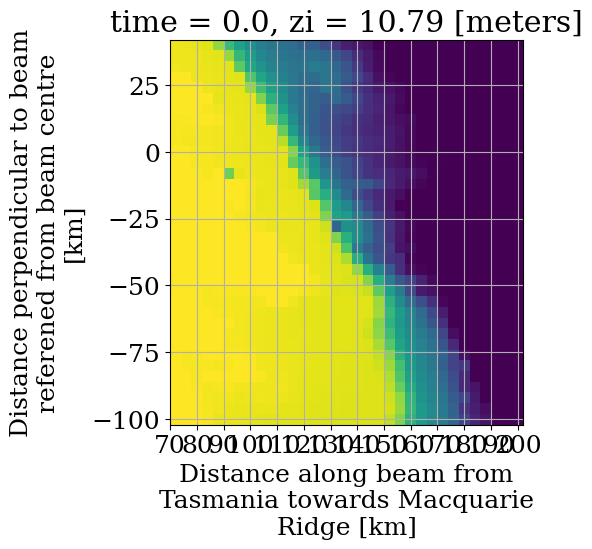

In [30]:
fig,ax = plt.subplots(1,1,figsize=(10, 5))
data["full-20"].bathy.sel(xb = slice(70,200),yb = slice(-100,40)).isel(time = 0).plot(vmin = -3000,vmax = 0,ax = ax,add_colorbar = False)
ax.set_xticks(np.arange(70,201,10))
ax.set_xticklabels(np.arange(70,201,10))
ax.grid()
ax.set_aspect("equal")

## Check flux on either side of the seamount. Do we get extra conversion in 20th compared to 10th?



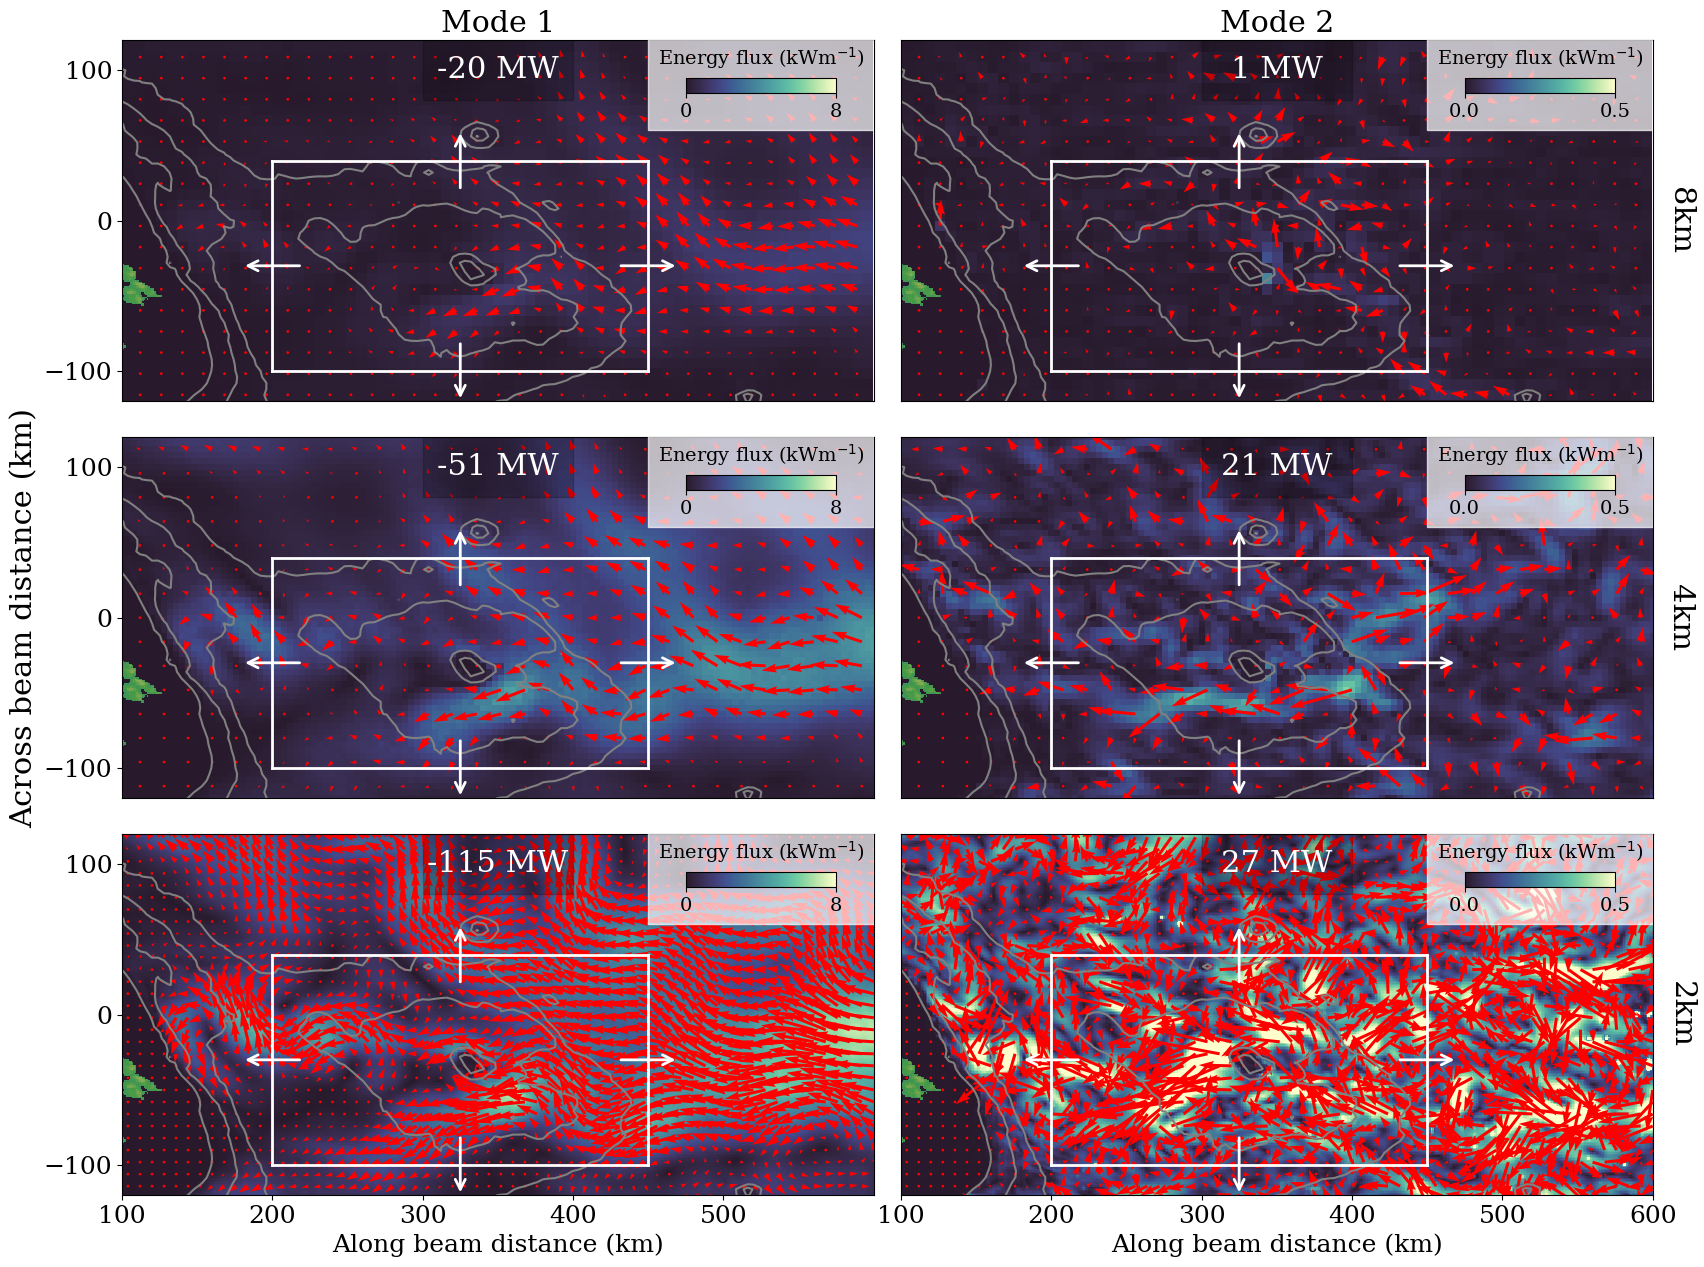

In [11]:
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

def plot_KE_quiver(alongbeam,acrossbeam,ax,xlim = slice(0,600),ylim = slice(-130,130),arrow_scale = 3000,mag_scale = 3000,mod_scale = 1,xs = [[90, 220]], ys = [ [120, -120]],signs = [1],spacing = 2):
    # expt = "full-20"
    arrow_scale *= mod_scale
    mag_scale *= mod_scale
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim)


    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")

    energy = 0
    length = 0
    for x,y,s in zip(xs,ys,signs):

        integral = contour_integral(x,y,alongbeam,acrossbeam)
        # print(1e-6 * s * integral.energy.values)
        energy += s * integral.energy.values
        length += integral.length.values
    # print()
    total = energy *1e-3

    _yb = acrossbeam.yb[::spacing]
    _xb = acrossbeam.xb[::spacing]
    _along = (alongbeam )[::spacing,::spacing]
    _across = (acrossbeam)[::spacing,::spacing]

    # print(magnitude)
    mag = np.sqrt(alongbeam**2 + acrossbeam**2)
    mag.plot(ax = ax,add_colorbar = False,cmap = cmocean.cm.deep_r,vmax = mag_scale)

    ax.quiver(_xb, _yb, _along, _across, color="red", scale=arrow_scale,scale_units = "width",width = 0.004)
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    ax.set_ylim(-120,120)
    ax.set_xlim(0,1200)
    ax.set_xlabel("")
    ax.set_ylabel("")

    ## Add patch and print the total integrated flux on it
    patch = ax.add_patch(matplotlib.patches.Rectangle((300, 80), 100, 40, color='black', alpha=0.2))
    
    ax.annotate(
        f"{total:.0f} MW",
        xy=(350, 100),  # Position of the text
        xycoords='data',  # Use data coordinates
        fontsize=22,
        color="white",
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
    )



top,bottom,left,right = 40,-100,200,450
xtop,xbottom,xleft,xright = [left,right],[left,right],[left,left],[right,right]
ytop,ybottom,yleft,yright = [top,top],[bottom,bottom],[bottom,top],[bottom,top]
xs = [xtop,xbottom,xleft,xright]
ys = [ytop,ybottom,yleft,yright]
signs = [1,-1,-1,1]



xmax = 40
# fig,ax = plt.subplots(3,2,figsize=(20,20))
fig = plt.figure(figsize = (20,15))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1],hspace = 0.1,wspace = 0.01)

ax = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]
ax = np.array(ax).reshape(3,2)

toplot = data[expt].mean("time")
# toplot = data[expt].isel(time = 1)

for a in ax.flatten():
    toplot.sel(xb = slice(0,xmax)).bathy.plot(vmax = 0, vmin = -4000, cmap = cmocean.cm.deep_r,ax = a,add_colorbar = False)
    toplot.sel(xb=slice(0, xmax)).bathy.plot.contour(levels=[-1000,-2000,-3000],ax = a,colors = ["lightgrey","lightgrey","lightgrey"],linestyles = "dashed",lineweights = 2)

d = (data["full-10"] - data["beamless-10"]).isel(mode = [0]).mean("time")
plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[0,0],mag_scale = 8000,arrow_scale = 50000,xs = xs,ys = ys,signs = signs)
d = (data["full-10"] - data["beamless-10"]).isel(mode = slice(1,None)).mean("time")
plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[0,1],mag_scale = 500,arrow_scale = 2000,xs = xs,ys = ys,signs = signs)
d = (data["full-20"] - data["beamless-20"]).isel(mode = [0]).mean("time")
plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[1,0],mag_scale = 8000,arrow_scale = 100000,xs = xs,ys = ys,signs = signs,spacing = 4)
d = (data["full-20"] - data["beamless-20"]).isel(mode = slice(1,None)).mean("time")
plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[1,1],mag_scale = 500,arrow_scale = 4000,xs = xs,ys = ys,signs = signs,spacing = 4)
d = (data["full-80"] - data["beamless-80"]).isel(mode = [0]).mean("time")
plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[2,0],mag_scale = 8000,arrow_scale = 100000,xs = xs,ys = ys,signs = signs,spacing = 8)
d = (data["full-80"] - data["beamless-80"]).isel(mode = slice(1,None)).mean("time")
plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[2,1],mag_scale = 500,arrow_scale = 8000,xs = xs,ys = ys,signs = signs,spacing = 8)
# d = (data["full-80"] - data["beamless-80"]).isel(mode = [0]).mean("time")
# plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[6],mag_scale = 40000,arrow_scale = 100000,xs = xs,ys = ys,signs = signs)
# d = (data["full-80"] - data["beamless-80"]).isel(mode = [1]).mean("time")
# plot_KE_quiver(d.EF_alongbeam,d.EF_acrossbeam,ax[7],mag_scale = 1000,arrow_scale = 20000,xs = xs,ys = ys,signs = signs)

for a in ax.flatten():
    data["full-20"].bathy.isel(time = 0).plot.contour(ax = a,levels = [-4000,-3000,-2000,-1000],colors= ["grey","grey","grey"])
    a.set_title("")
    a.set_ylabel("")
    a.set_xlabel("")
    a.set_xlim(100,600)
    a.set_xticks([])
    a.set_yticks([])
    # a.set_ylim(-120,80)
    a.set_aspect("equal")
    a.plot(xtop,ytop,color = "white",lw = 2)
    a.plot(xbottom,ybottom,color = "white",lw = 2)
    a.plot(xleft,yleft,color = "white",lw = 2)
    a.plot(xright,yright,color = "white",lw = 2)
    alen = 20
    a.annotate("",xytext=(np.mean(np.array(xtop)), ytop[0] - alen), xy=(np.mean(np.array(xtop)), ytop[0] + alen), arrowprops=dict(arrowstyle="->", color="white", lw=2))
    a.annotate("",xytext=(np.mean(np.array(xbottom)), ybottom[0] + alen), xy=(np.mean(np.array(xbottom)), ybottom[0] - alen), arrowprops=dict(arrowstyle="->", color="white", lw=2))
    a.annotate("",xytext=(xright[0] - alen,np.mean(np.array(yright))), xy=(xright[0] + alen,np.mean(np.array(yright))), arrowprops=dict(arrowstyle="->", color="white", lw=2))
    a.annotate("",xytext=(xleft[0] + alen,np.mean(np.array(yleft))), xy=(xleft[0] - alen,np.mean(np.array(yleft))), arrowprops=dict(arrowstyle="->", color="white", lw=2))

# Incoming: -183.1 -13.8 kW/m
# Outgoing: 72.1 8.0 kW/m
# Xterm: 21.5 -0.3 kW/m

ax[0,0].set_title("Mode 1")
ax[0,1].set_title("Mode 2")
ax[1,0].set_ylabel("Across beam distance (km)")
ax[1,0].set_yticks([-100,0,100])
ax[2,0].set_yticks([-100,0,100])
ax[0,0].set_yticks([-100,0,100])
ax[0,1].set_ylabel("8km",rotation = 270,labelpad = 30)
ax[1,1].set_ylabel("4km",rotation = 270,labelpad = 30)
ax[2,1].set_ylabel("2km",rotation = 270,labelpad = 30)
for i in range(3):
    ax[i,1].yaxis.set_label_position("right")  # Set the label position to the rightax[i,1].tick_params(axis='y', labelsize=22)  # Set font size for y-axis labels
    # ax[i,0].set_yticks([-100,0,100])
    ax[i,1].yaxis.label.set_size(22)  # Set font size for y-axis labels
    ax[i,0].yaxis.label.set_size(22)  # Set font size for y-axis labels

ax[2,0].set_xlabel("Along beam distance (km)")
ax[2,1].set_xlabel("Along beam distance (km)")
ax[2,0].yaxis.label.set_size(22)
ax[2,1].yaxis.label.set_size(22)
ax[2,0].set_xticks([100,200,300,400,500])
ax[2,1].set_xticks([100,200,300,400,500,600])
# ax[2,1].set_xticks([0,100,200,300,400])

umax = 1
efmax = 1
for i in range(3):
    for j,scale in enumerate([8,0.5]):
        patch = ax[i,j].add_patch(matplotlib.patches.Rectangle((450, 60), 150, 70, color='white', alpha=0.7))
        cax1 = ax[i,j].inset_axes([475, 85, 100, 10],transform=ax[i,j].transData)  # Adjust size and location
        patch.set_zorder(9)
        cax1.set_zorder(10)  # Bring the patch to the front
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(cmap=cmocean.cm.deep_r, norm=plt.Normalize(vmin=0, vmax=scale)),
            cax=cax1,
            orientation='horizontal',
            location="bottom",
            label=r"Energy flux (kWm$^{-1}$)",
        )
        cbar.ax.xaxis.set_label_coords(0.5, 3.2)  # Adjust the title position to be higher
        cbar.set_ticks([0,scale])
        cax1.tick_params(labelsize=14, color="black", labelcolor="black")  # Set font size and color for colorbar ticks
        cax1.xaxis.label.set_size(14)  # Set font size for colorbar label
        cax1.xaxis.label.set_color("black")  # Set label color to black


